**Setup Environment**

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import TextVectorization, Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout

In [2]:
# Load the dataset 
path_to_file = get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt') 
text = open(path_to_file, 'rb').read().decode(encoding='utf-8') 

# Preview the dataset 
print(text[:1000]) 

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [3]:
# Preprocess the dataset 
vocab_size = 10000 
seq_length = 100 

# Adapt TextVectorization to full text 
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int') 
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1) 
vectorizer.adapt(text_ds) 

# Vectorize the text 
vectorized_text = vectorizer([text])[0] 
print("Vectorized text shape:", vectorized_text.shape) 
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10]) 

Vectorized text shape: (202646,)
First 10 vectorized tokens: [ 89 270 138  36 982 144 673 125  16 106]


**Create Input and Target Sequences**

In [4]:
def create_sequences(text, seq_length): 
    input_seqs = [] 
    target_seqs = [] 
    for i in range(len(text) - seq_length): 
        input_seq = text[i:i + seq_length] 
        target_seq = text[i + 1:i + seq_length + 1] 
        input_seqs.append(input_seq) 
        target_seqs.append(target_seq) 
    return np.array(input_seqs), np.array(target_seqs) 

# Generate sequences 
X, Y = create_sequences(vectorized_text.numpy(), seq_length) 

# Check if sequences are correctly generated 
print("Number of sequences generated:", len(X)) 
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated") 

# Check if X and Y are not empty 
assert X.size > 0, "Input data X is empty" 
assert Y.size > 0, "Target data Y is empty" 
X = tf.convert_to_tensor(X) 
Y = tf.convert_to_tensor(Y) 
print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape)

Number of sequences generated: 202546
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79  506   27    3   56   24 1390
   57   40  161 2328  644    9 4980   34   32   54 2863  885   72   17
   18  163  146  146  165  270   74  218   46  595   89  270   36   41
 6739  172  595    2 1780   46   29 1323 5151   47   58 4151   79   39
   60   58]
Shape of X: (202546, 100)
Shape of Y: (202546, 100)


**Build Transformer Model**

In [5]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(Model):  # Model is now properly imported
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.dense = Dense(vocab_size)

    def positional_encoding(self, seq_length, embed_dim):
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :seq_len, :]
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)  # Pass training argument correctly
        output = self.dense(x)
        return output

In [6]:
# Hyperparameters 
embed_dim = 256 
num_heads = 4 
ff_dim = 512 
num_layers = 4 

# Build the Transformer model 
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)

# Provide input shape to build the model by passing a dummy input with maxval specified
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))

# Compile the model 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Summary of the model 
model.summary()

Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2560000   
                                                                 
 transformer_block (Transfor  multiple                 1315840   
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  multiple                 1315840   
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  multiple                 1315840   
 ormerBlock)                                                     
                                                                 
 transformer_block_3 (Transf  multiple                 1315840   
 ormerBlock)                                     

**Train Transformer Model**

Epoch 1/20
6330/6330 [==============================] - 7485s 1s/step - loss: 11.9195
Epoch 2/20
6330/6330 [==============================] - 7724s 1s/step - loss: 12.1425
Epoch 3/20
6330/6330 [==============================] - 8718s 1s/step - loss: 12.3478


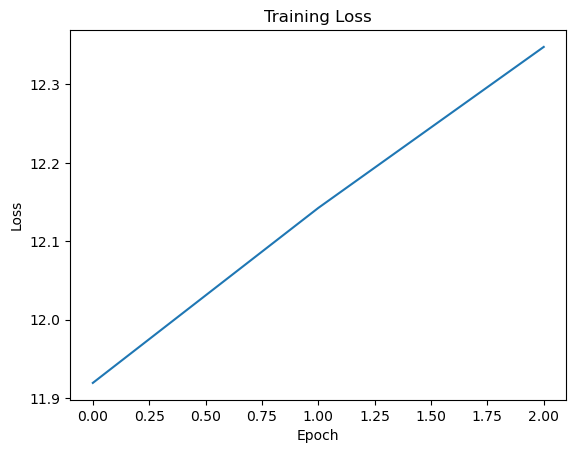

In [7]:
# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Train the transformer model on the full input and target sequences
history = model.fit(X, Y, epochs=20, batch_size=32, callbacks=[early_stopping])

# Plot training loss to monitor model performance over epochs
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

**Generate Text with Trained Model**

In [13]:
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    # Convert the start string to a vectorized format
    input_eval = vectorizer([start_string]).numpy()
    
    # Ensure the input length matches the model's expected input shape
    if input_eval.shape[1] < seq_length:
        # Pad the input if it's shorter than the expected sequence length
        padding = np.zeros((1, seq_length - input_eval.shape[1]))
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
        # Truncate the input if it's longer than the expected sequence length
        input_eval = input_eval[:, -seq_length:]

    input_eval = tf.convert_to_tensor(input_eval)
    
    # Initialize an empty list to store generated text
    text_generated = []

    # Start generating text
    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)  # Assuming output shape is [batch_size, vocab_size]

        # Check the number of dimensions in predictions
        if len(predictions.shape) == 3:
            # Extract logits for the last timestep
            predictions = predictions[:, -1, :]  # Shape becomes [batch_size, vocab_size]
        elif len(predictions.shape) == 2:
            # If predictions are already 2D, use them as is
            pass
        else:
            raise ValueError(f"Unexpected predictions shape: {predictions.shape}")

        # Apply temperature to predictions
        predictions = predictions / temperature

        # Use a categorical distribution to predict the next word
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)  # Append predicted token
        input_eval = input_eval[:, -seq_length:]  # Keep only the last `seq_length` tokens
        input_eval = tf.convert_to_tensor(input_eval)  # Convert back to tensor

        # Append the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    # Return the generated text starting from the initial seed
    return start_string + ' ' + ' '.join(text_generated)

# Generate text with temperature control
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string, temperature=0.7)  # Lower temperature for more focused predictions
print(generated_text)

To be, or not to be                                                                                                    


**Experiment with Different Sequence Lengths**

Number of samples in the dataset: 30
Dataset is very small. Using 50% of the data for training.
Shape of X: (24, 5, 1)
Shape of Y: (24,)
Epoch 1/5
3/3 [==============================] - 1s 5ms/step - loss: 2.2468
Epoch 2/5
3/3 [==============================] - 0s 4ms/step - loss: 0.2849
Epoch 3/5
3/3 [==============================] - 0s 4ms/step - loss: 0.3469
Epoch 4/5
3/3 [==============================] - 0s 3ms/step - loss: 0.1903
Epoch 5/5
3/3 [==============================] - 0s 4ms/step - loss: 0.2800


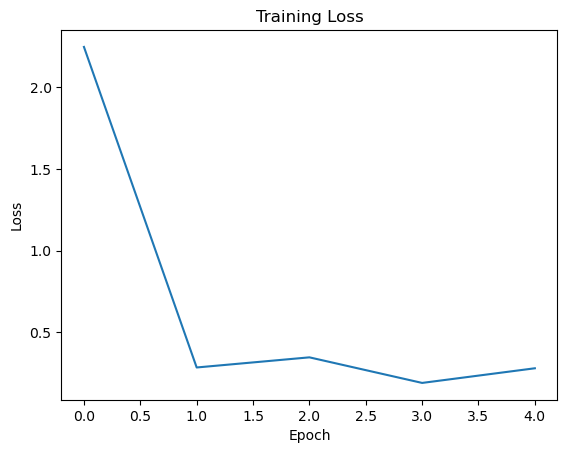

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input

# Example: Load a time-series dataset
data_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WHA_mc9FWSVjCGLSLAp48A/stock-prices.csv'
df = pd.read_csv(data_url)

# Select the 'Close' column for training (or any relevant column for your task)
data = df[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Check the number of samples in the data
n_samples = data.shape[0]
print(f"Number of samples in the dataset: {n_samples}")

# Ensure we have enough data by setting a reasonable train size
if n_samples < 100:
    print("Dataset is very small. Using 50% of the data for training.")
    train_size = 0.5  # Use 50% of data if we have less than 100 samples
    seq_length = 5    # Use a shorter sequence length for very small datasets
else:
    train_size = 0.1  # Use 10% of data for larger datasets
    seq_length = 50   # Change sequence length to 50 for larger datasets

# Reduce dataset size for quicker runs
X, _, Y, _ = train_test_split(data, data, train_size=train_size, random_state=42)  # Adjust train_size based on data

# Preprocess the dataset with adjusted sequence length
def create_dataset(data, time_step=seq_length):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

X, Y = create_dataset(data, seq_length)

# Check if the generated sequences have valid shapes
if X.size == 0 or Y.size == 0:
    raise ValueError(f"The dataset is too small to create sequences with a length of {seq_length}. Reduce the sequence length or use a larger dataset.")

X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

# Define a simpler Transformer Block for faster runs
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):  # Set training argument default to False
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build and compile the model
input_shape = (X.shape[1], X.shape[2])
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Dense(64)(inputs)  # Reduced embed_dim for faster runs
transformer_block = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)  # Reduced model complexity
x = transformer_block(x, training=True)  # Pass training argument here
flatten = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mse')

# Early stopping to stop training when no improvement is seen
early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

# Dynamically calculate steps_per_epoch
batch_size = 8
steps_per_epoch = max(len(X) // batch_size, 1)

# Adjust steps_per_epoch directly
history = model.fit(X, Y, epochs=5, batch_size=batch_size, steps_per_epoch=steps_per_epoch, callbacks=[early_stopping])

# Plot training loss
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

**Add a Learning Rate Scheduler**

Epoch 1/20
1/1 [==============================] - 1s 696ms/step - loss: 0.0705 - lr: 0.0010
Epoch 2/20
1/1 [==============================] - 0s 6ms/step - loss: 0.1507 - lr: 0.0010
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.2114 - lr: 0.0010
Epoch 4/20
1/1 [==============================] - 0s 6ms/step - loss: 0.1932 - lr: 0.0010
Epoch 5/20
1/1 [==============================] - 0s 6ms/step - loss: 0.1976 - lr: 0.0010
Epoch 6/20
1/1 [==============================] - 0s 6ms/step - loss: 0.1666 - lr: 0.0010
Epoch 7/20
1/1 [==============================] - 0s 6ms/step - loss: 0.1535 - lr: 0.0010
Epoch 8/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0904 - lr: 0.0010
Epoch 9/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1412 - lr: 0.0010
Epoch 10/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1867 - lr: 0.0010
Epoch 11/20
1/1 [==============================] - 0s 7ms/step - loss: 0.2306 - lr: 5.0000e-04
Ep

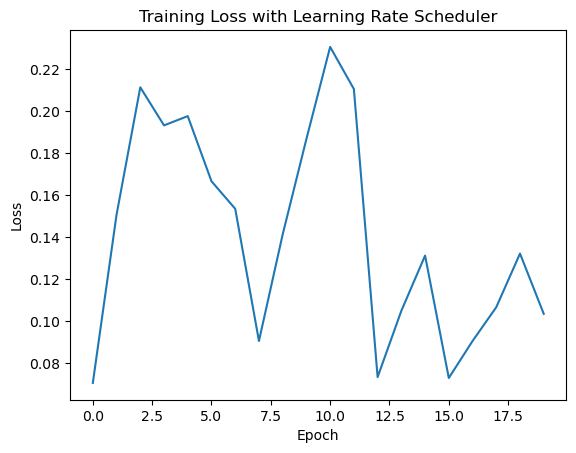

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input

# Define a learning rate scheduler  
def scheduler(epoch, lr):  
    if epoch % 10 == 0 and epoch != 0:  
        lr = lr * 0.5  
    return lr  

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)  

# Train the model with the learning rate scheduler  
history = model.fit(X, Y, epochs=20, batch_size=64, callbacks=[callback])  

# Plot the training loss  
plt.plot(history.history['loss'])  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Training Loss with Learning Rate Scheduler')  
plt.show() 

**Generate Longer Text Sequences**

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Input


def generate_text(model, start_string, num_generate=200):
    # Convert the start string to numbers (vectorize)
    input_eval = vectorizer([start_string]).numpy()

    # Ensure the input tensor has the correct shape
    input_eval = tf.convert_to_tensor(input_eval[:, -5:])  # Ensure it has a shape of (1, 5)
    
    text_generated = []

    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)

        # Ensure predictions is a matrix with shape [batch_size, num_classes]
        predictions = tf.squeeze(predictions, 0)  # Remove the batch dimension
        predictions = tf.expand_dims(predictions, 0)  # Add back a batch dimension for categorical
        
        # Use a categorical distribution to predict the next word
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)  # Append predicted token
        input_eval = input_eval[:, -5:]  # Keep only the last 5 tokens to match input shape
        input_eval = tf.convert_to_tensor(input_eval)  # Convert back to tensor
        
        # Add the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])

    return start_string + ' ' + ' '.join(text_generated)

# Generate longer text
start_string = "To be, or not to be"
generated_text = generate_text(model, start_string)

print(generated_text)

To be, or not to be                                                                                                                                                                                                        
